In [ ]:
from google.colab import files
from tensorflow.keras import utils
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, CuDNNLSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#http://marsyas.info/downloads/datasets.html

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import zipfile
import io
z = zipfile.ZipFile('/content/drive/My Drive/genres.zip', 'r') # распакуем файлы
z.extractall()
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split() # типы музыки
!ls genres 
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
# Используя библиотеку librosa извлечем статистику по сигналам и добавим все в список (features)
def get_features(y, sr):
  chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
  rmse = np.mean(librosa.feature.rmse(y=y))
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  
  out = [] 
  out.append(chroma_stft)
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)
  
  for e in mfcc:
    out.append(np.mean(e))
  
  return out

In [ ]:
X_train = []
Y_train = []

for i in range(len(genres)):  # для каждого жанра
  g = genres[i]
  for filename in os.listdir(f'./genres/{g}'): # для каждого аудиофрагмента
    songname = f'./genres/{g}/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30) # загружаем
    out = get_features(y, sr) # извлекаем показатели
    
    X_train.append(out)
    Y_train.append(utils.to_categorical(i, len(genres)))
  print("Жанр", g, "готов")

X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов
Жанр classical готов
Жанр country готов
Жанр disco готов
Жанр hiphop готов
Жанр jazz готов
Жанр metal готов
Жанр pop готов
Жанр reggae готов
Жанр rock готов


In [ ]:
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 26)
(1000, 10)
(1000,)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(X_train, dtype = float)) # масштабируем данные

In [ ]:
print(X_train.shape)

(900, 26)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1) # разделим на тренировку и тест

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 26)
(900,)
(100, 26)
(100,)


Train on 900 samples, validate on 100 samples
Epoch 1/200
900/900 [==============================] - 1s 680us/step - loss: 2.0681 - acc: 0.2700 - val_loss: 1.8295 - val_acc: 0.3800
Epoch 2/200
900/900 [==============================] - 0s 109us/step - loss: 1.7621 - acc: 0.3844 - val_loss: 1.6814 - val_acc: 0.3800
Epoch 3/200
900/900 [==============================] - 0s 109us/step - loss: 1.6299 - acc: 0.4233 - val_loss: 1.5996 - val_acc: 0.4400
Epoch 4/200
900/900 [==============================] - 0s 109us/step - loss: 1.5355 - acc: 0.4622 - val_loss: 1.5476 - val_acc: 0.4300
Epoch 5/200
900/900 [==============================] - 0s 112us/step - loss: 1.4606 - acc: 0.4900 - val_loss: 1.4984 - val_acc: 0.4600
Epoch 6/200
900/900 [==============================] - 0s 108us/step - loss: 1.3990 - acc: 0.5189 - val_loss: 1.4505 - val_acc: 0.4900
Epoch 7/200
900/900 [==============================] - 0s 108us/step - loss: 1.3477 - acc: 0.5467 - val_loss: 1.4141 - val_acc: 0.5300
Epoch 8/2

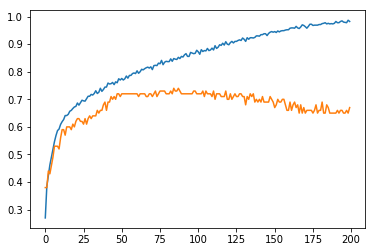

In [ ]:
indexes = range(0,26)

model = Sequential() # создаем архитектуру сети
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test)) # обучаем сетку

plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.show()

Train on 900 samples, validate on 100 samples
Epoch 1/120
900/900 [==============================] - 0s 304us/step - loss: 2.2336 - acc: 0.1900 - val_loss: 2.1248 - val_acc: 0.2000
Epoch 2/120
900/900 [==============================] - 0s 64us/step - loss: 2.0195 - acc: 0.2900 - val_loss: 1.9516 - val_acc: 0.3100
Epoch 3/120
900/900 [==============================] - 0s 73us/step - loss: 1.8771 - acc: 0.3556 - val_loss: 1.8374 - val_acc: 0.3500
Epoch 4/120
900/900 [==============================] - 0s 77us/step - loss: 1.7805 - acc: 0.3656 - val_loss: 1.7579 - val_acc: 0.3800
Epoch 5/120
900/900 [==============================] - 0s 83us/step - loss: 1.7121 - acc: 0.3767 - val_loss: 1.6992 - val_acc: 0.3900
Epoch 6/120
900/900 [==============================] - 0s 72us/step - loss: 1.6582 - acc: 0.3889 - val_loss: 1.6546 - val_acc: 0.4100
Epoch 7/120
900/900 [==============================] - 0s 82us/step - loss: 1.6133 - acc: 0.4056 - val_loss: 1.6150 - val_acc: 0.4400
Epoch 8/120
900

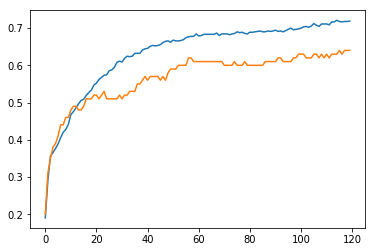

In [ ]:
indexes = range(0,26)

model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.show()

Train on 900 samples, validate on 100 samples
Epoch 1/120
900/900 [==============================] - 0s 342us/step - loss: 2.2842 - acc: 0.1389 - val_loss: 2.2260 - val_acc: 0.1900
Epoch 2/120
900/900 [==============================] - 0s 80us/step - loss: 2.1780 - acc: 0.1911 - val_loss: 2.1358 - val_acc: 0.2000
Epoch 3/120
900/900 [==============================] - 0s 65us/step - loss: 2.0947 - acc: 0.2111 - val_loss: 2.0669 - val_acc: 0.2000
Epoch 4/120
900/900 [==============================] - 0s 77us/step - loss: 2.0286 - acc: 0.2511 - val_loss: 2.0102 - val_acc: 0.2300
Epoch 5/120
900/900 [==============================] - 0s 71us/step - loss: 1.9758 - acc: 0.2967 - val_loss: 1.9644 - val_acc: 0.2500
Epoch 6/120
900/900 [==============================] - 0s 63us/step - loss: 1.9324 - acc: 0.3144 - val_loss: 1.9253 - val_acc: 0.3000
Epoch 7/120
900/900 [==============================] - 0s 74us/step - loss: 1.8957 - acc: 0.3244 - val_loss: 1.8920 - val_acc: 0.3000
Epoch 8/120
900

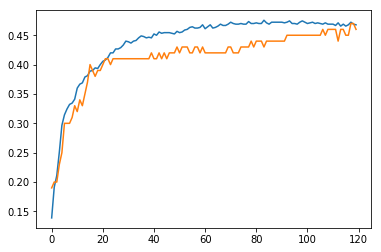

In [ ]:
indexes = range(0,6)

model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.show()

Train on 900 samples, validate on 100 samples
Epoch 1/120
900/900 [==============================] - 0s 394us/step - loss: 2.4521 - acc: 0.0611 - val_loss: 2.2947 - val_acc: 0.1200
Epoch 2/120
900/900 [==============================] - 0s 73us/step - loss: 2.2673 - acc: 0.1400 - val_loss: 2.1433 - val_acc: 0.2000
Epoch 3/120
900/900 [==============================] - 0s 70us/step - loss: 2.1407 - acc: 0.2322 - val_loss: 2.0409 - val_acc: 0.2600
Epoch 4/120
900/900 [==============================] - 0s 77us/step - loss: 2.0482 - acc: 0.2889 - val_loss: 1.9654 - val_acc: 0.3500
Epoch 5/120
900/900 [==============================] - 0s 71us/step - loss: 1.9757 - acc: 0.3233 - val_loss: 1.9060 - val_acc: 0.3400
Epoch 6/120
900/900 [==============================] - 0s 69us/step - loss: 1.9170 - acc: 0.3444 - val_loss: 1.8592 - val_acc: 0.3400
Epoch 7/120
900/900 [==============================] - 0s 70us/step - loss: 1.8676 - acc: 0.3511 - val_loss: 1.8183 - val_acc: 0.3700
Epoch 8/120
900

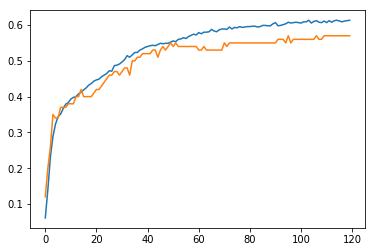

In [ ]:
indexes = range(6,26)

model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.show()

#Архитектуры с softmax

Train on 900 samples, validate on 100 samples
Epoch 1/600
900/900 [==============================] - 1s 763us/step - loss: 2.4083 - acc: 0.0844 - val_loss: 2.3879 - val_acc: 0.1100
Epoch 2/600
900/900 [==============================] - 0s 81us/step - loss: 2.3688 - acc: 0.1056 - val_loss: 2.3508 - val_acc: 0.1100
Epoch 3/600
900/900 [==============================] - 0s 79us/step - loss: 2.3346 - acc: 0.1144 - val_loss: 2.3159 - val_acc: 0.1100
Epoch 4/600
900/900 [==============================] - 0s 79us/step - loss: 2.3036 - acc: 0.1367 - val_loss: 2.2868 - val_acc: 0.1200
Epoch 5/600
900/900 [==============================] - 0s 78us/step - loss: 2.2760 - acc: 0.1667 - val_loss: 2.2596 - val_acc: 0.1300
Epoch 6/600
900/900 [==============================] - 0s 76us/step - loss: 2.2506 - acc: 0.1911 - val_loss: 2.2345 - val_acc: 0.2200
Epoch 7/600
900/900 [==============================] - 0s 82us/step - loss: 2.2272 - acc: 0.2178 - val_loss: 2.2108 - val_acc: 0.2500
Epoch 8/600
900

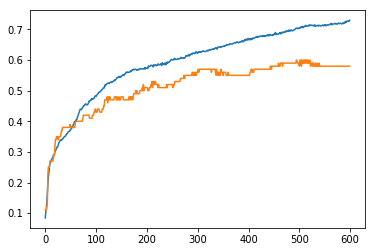

In [ ]:
# протестируем другие архтектуры и активационные функции (в частности, softmax в полносвяфзных слоях)

indexes = range(0,26)

input1 = Input((len(indexes),))

x1 = Dense(10, activation="elu")(input1)
x1 = Dense(10, activation="elu")(x1)

x2 = Dense(10, activation="elu")(input1)
x2 = Dense(40, activation="softmax")(x2)

x = concatenate([x1, x2])

x = Dense(10, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)

model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=600,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.show()

Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 1s 1ms/step - loss: 2.1954 - acc: 0.2611 - val_loss: 2.0368 - val_acc: 0.3400
Epoch 2/1000
900/900 [==============================] - 0s 161us/step - loss: 1.9869 - acc: 0.3589 - val_loss: 1.8741 - val_acc: 0.3600
Epoch 3/1000
900/900 [==============================] - 0s 150us/step - loss: 1.8570 - acc: 0.3500 - val_loss: 1.7742 - val_acc: 0.3500
Epoch 4/1000
900/900 [==============================] - 0s 159us/step - loss: 1.7655 - acc: 0.3578 - val_loss: 1.7031 - val_acc: 0.3600
Epoch 5/1000
900/900 [==============================] - 0s 148us/step - loss: 1.6975 - acc: 0.3700 - val_loss: 1.6481 - val_acc: 0.3700
Epoch 6/1000
900/900 [==============================] - 0s 153us/step - loss: 1.6405 - acc: 0.3856 - val_loss: 1.6050 - val_acc: 0.3900
Epoch 7/1000
900/900 [==============================] - 0s 150us/step - loss: 1.5904 - acc: 0.4089 - val_loss: 1.5647 - val_acc: 0.3900
Epoc

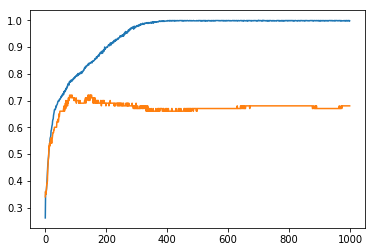

In [ ]:
indexes = range(0,26)

input1 = Input((len(indexes),))

x1 = Dense(64, activation="elu")(input1)
x1 = Dense(64, activation="elu")(x1)

x2 = Dense(64, activation="elu")(input1)
x2 = Dense(40, activation="softmax")(x2)

x3 = Dense(64, activation="elu")(input1)
x3 = Dense(200, activation="softmax")(x3)

x4 = Dense(40, activation="softmax")(input1)

x5 = Dense(200, activation="softmax")(input1)

x6 = Dense(10, activation="softmax")(input1)

x7 = Dense(64, activation="elu")(input1)
x7 = Dense(10, activation="softmax")(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(64, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)

model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=1000,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.show()

#Распознавание выбранной песни

In [ ]:
print(genres)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
!ls genres/rock

In [ ]:
songname = f'./genres/rock/rock.00000.au'
y, sr = librosa.load(songname, mono=True, duration=30) # загружаем песню
out1 = get_features(y, sr) # считаем статистику сигнала

In [ ]:
out1 = np.array(out1).reshape(1,26)
out1 = scaler.transform(out1)

y1 = model.predict(out1) # делаем предсказание
print(y1)
print(np.argmax(y1)) # жанр с наибольшей вероятностью